### 1. Load facies models

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
import os
%matplotlib inline
import matplotlib.pyplot as plt

# file and label path for original facies maps
Filepath = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/2D_AllPro_Gslib_fromPetrel(version4)'  # facies maps
labels_path = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/labels(version4).txt'   # labels

##### Read facies model values and convert into an array of 35640x64x64

In [2]:
allele=[]  
# stores all facies code values of the file. includes 64x64 lists, and each list includes code values of all realizations at each pixel.

with open (Filepath) as fl:
    for line in fl:
        eles = line.strip().split(' ')
       
        if len(eles)>=5:    # filter the lines with property name "Facies unit1 scale1"        
            allele.append(eles)
            
faciesimgs = np.array(allele, dtype = float).reshape((64, 64, -1)).astype(int)

faciesimgs = np.where(faciesimgs == 1, 4, faciesimgs)/2 # originally, 1 for channel sand facies, and 2 for channel bank; here exchange their codes.
faciesimgs = np.concatenate((faciesimgs, faciesimgs[::-1,:,:]),2)  # flip faciesimgs along north-south direction 
faciesimgs = np.transpose(faciesimgs, (2, 0, 1))  # transpose into (?, 64, 64) 

print(faciesimgs.shape)    

(35640, 64, 64)


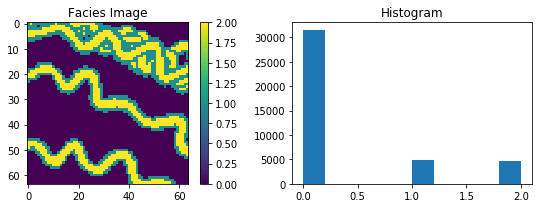

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 3))  

# First subplot: facies image
im = ax[0].imshow(faciesimgs[11011])
fig.colorbar(im, ax=ax[0]) 
ax[0].set_title("Facies Image")

# Second subplot: histogram
ax[1].hist(faciesimgs[:10].reshape(-1))
ax[1].set_title("Histogram")

plt.tight_layout()
plt.show()


##### These facies models have the facies codes of [0, 1, 2]

* 0: inter-channel mud facies
* 1: channel levee facies
* 2: channel center facies

### 2. Load global features

Global features (labels) include channel direction, mud proportion, channel center width, channel amplitude, and channel wavelength. The channel direction, -90 to 90 degrees clockwise from the north direction, is equally divided into 30 categories, with each category corresponds to 6 degrees. The channel center width can be 27, 31, or 34 m with equal probability. The channel amplitude is from 7 to 111 m. The channel wavelength can be 100, 120, 140, or 160 m. The mud proportion ranges from 0.14 to 0.59. 

The mud proportion is calcualted from the facies maps while other four global features are directly loaded.

**Load original global features (labels)**

The five global features in the following all_labels_arr are channel number, channel orientation, channel center width, channel wavelength, channel amplitude.

In [4]:
labels_list = []  # Store all labels from the label file

# Read label file and split each line by double space
with open(labels_path) as lb:
    for line in lb:
        labels_list.append(line.strip().split('  '))

n_orig_labels = len(labels_list) 
labels_array = np.array(labels_list, dtype=np.float).reshape(n_orig_labels, 5).astype(np.float)

# divide channel direction from 0 to 90 degrees into 15 categories
labels_array[:, 1] = labels_array[:, 1] / 6 + 1  

all_labels_arr = np.empty((n_orig_labels*6,5), dtype=np.float)
# Every label corresponds to 3 consecutive facies models, thus labels are mutiplied by 3.
all_labels_arr[:n_orig_labels*3:3,:]=labels_array
all_labels_arr[1:n_orig_labels*3:3,:]=labels_array
all_labels_arr[2:n_orig_labels*3:3,:]=labels_array

# repeat global features for facies models flipped along north-south direction
# negativize orientation of original facies models before flipping; the orientation of flipped facies models are original positive.
all_labels_arr[:n_orig_labels*3,1]=all_labels_arr[:n_orig_labels*3,1]*(-1) 
# Other labels for the flipped facies models remain the same. 
all_labels_arr[n_orig_labels*3:n_orig_labels*6:3,:]=labels_array
all_labels_arr[n_orig_labels*3+1:n_orig_labels*6:3,:]=labels_array
all_labels_arr[n_orig_labels*3+2:n_orig_labels*6:3,:]=labels_array

print(all_labels_arr.shape)

(35640, 5)


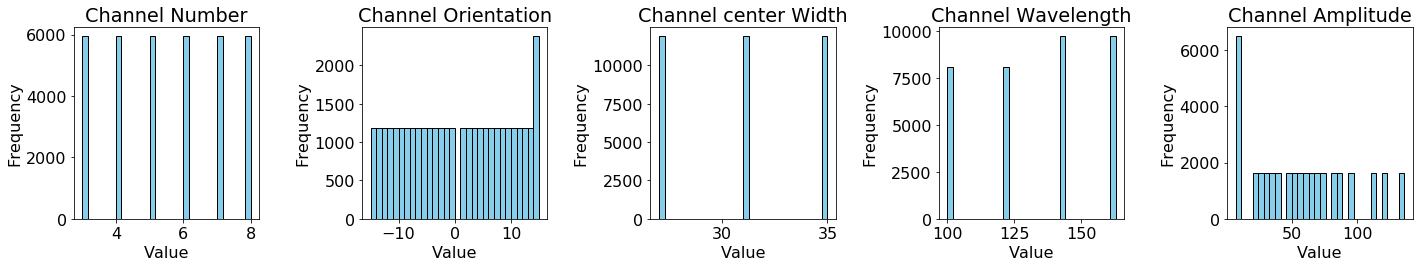

In [5]:
column_names = [
    "Channel Number",         # Column 0
    "Channel Orientation",    # Column 1
    "Channel center Width",          # Column 2
    "Channel Wavelength",     # Column 3
    "Channel Amplitude"       # Column 4
]

# Set global font size
plt.rcParams.update({'font.size': 16})

# Plot histograms for each column
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].hist(all_labels_arr[:, i], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(column_names[i])
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


**Discretize Orientation, Calculate Background Mud Proportion, and Normalize Global Features (Labels) into [-1, 1]**

In [6]:
# Initialize container for 34-dimensional label vector:
# - 30 orientation categories (one-hot)
# - 1 normalized background ratio
# - 1 normalized channel width
# - 1 normalized wavelength
# - 1 normalized amplitude
labels_cor = np.empty((all_labels_arr.shape[0], 34), dtype=np.float)

# ===== Orientation: discretize into 30 classes and one-hot encode =====
# Orientation is in column 1 of all_labels_arr
orit = all_labels_arr[:, 1]
# Adjust orientation class index into range [0, 29]
orit_class = np.where(orit < 0, orit + 1, orit) + 14  # shift to [0, 29]
num_classes = 30
orit_one_hot = np.eye(num_classes)[orit_class.astype(int)]  # (n_samples, 30)

# Assign one-hot orientation to first 30 columns
labels_cor[:, :30] = orit_one_hot

# Compute background ratio and normalize to [-1, 1]
back_ratio = 1 - np.count_nonzero(faciesimgs, axis=(1, 2)) / (64 * 64)
labels_cor[:, 30] = ((back_ratio - np.min(back_ratio)) / (np.max(back_ratio) - np.min(back_ratio)) - 0.5) * 2

# ===== Normalize channel width to [-1, 1] =====
width = all_labels_arr[:, 2]
labels_cor[:, 31] = ((width - np.min(width)) / (np.max(width) - np.min(width)) - 0.5) * 2

# ===== Normalize wavelength to [-1, 1] =====
wvl = all_labels_arr[:, 3]
labels_cor[:, 32] = ((wvl - np.min(wvl)) / (np.max(wvl) - np.min(wvl)) - 0.5) * 2

# ===== Normalize amplitude to [-1, 1], with upper cap at 111 =====
amplt = all_labels_arr[:, 4]
amplt = np.where(amplt >= 111, 111, amplt)
labels_cor[:, 33] = ((amplt - np.min(amplt)) / (np.max(amplt) - np.min(amplt)) - 0.5) * 2

print("labels_cor shape:", labels_cor.shape)


labels_cor shape: (35640, 34)


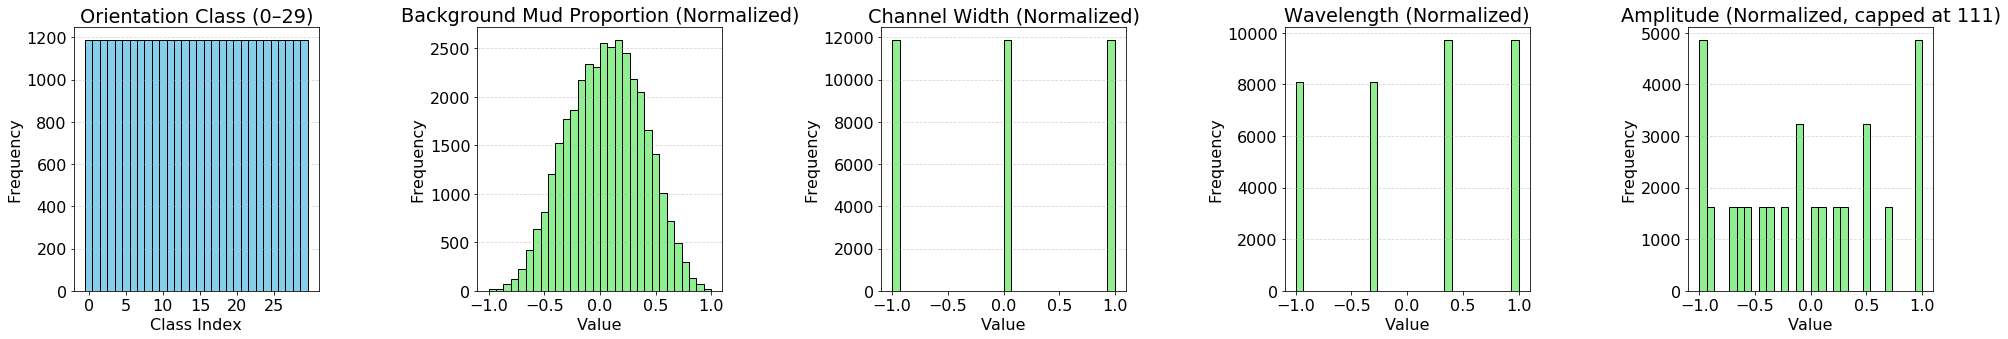

In [7]:
# Feature names: first is orientation class, then the four normalized global features
feature_names = [
    'Orientation Class (0–29)',
    'Background Mud Proportion (Normalized)',
    'Channel Width (Normalized)',
    'Wavelength (Normalized)',
    'Amplitude (Normalized, capped at 111)'
]

fig, axes = plt.subplots(1, 5, figsize=(28, 5))

# Plot orientation class histogram
axes[0].hist(orit_class, bins=np.arange(31) - 0.5, edgecolor='black', color='skyblue')
axes[0].set_title(feature_names[0])
axes[0].set_xlabel('Class Index')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(np.arange(0, 30, 5))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Plot histograms for normalized global features
for i in range(4):
    axes[i + 1].hist(labels_cor[:, 30 + i], bins=30, edgecolor='black', color='lightgreen')
    axes[i + 1].set_title(feature_names[i + 1])
    axes[i + 1].set_xlabel('Value')
    axes[i + 1].set_ylabel('Frequency')
    axes[i + 1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


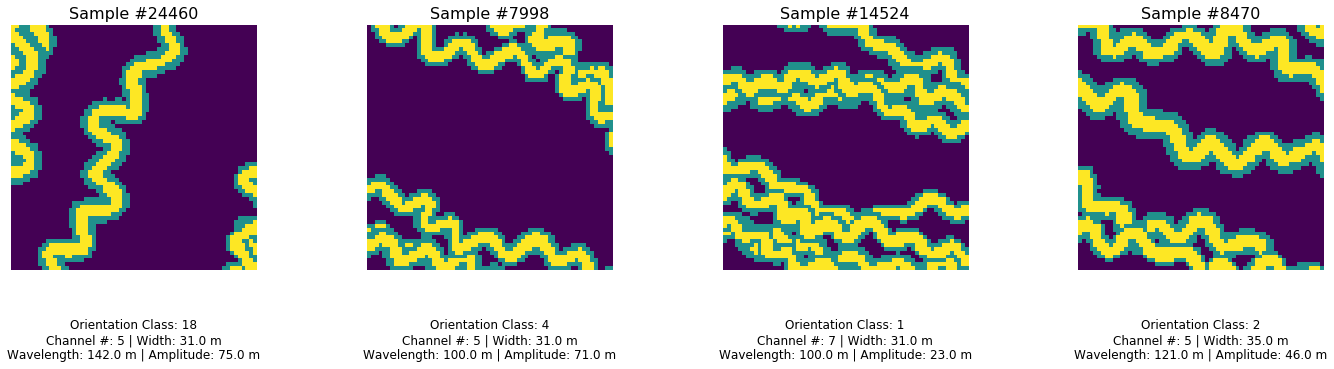

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Global feature column meanings in all_labels_arr
feature_names = [
    "Channel Number (Discrete)",     # column 0
    "Orientation Class (0–29)",      # from orit_class
    "Channel Width (m)",             # column 2
    "Wavelength (m)",                # column 3
    "Amplitude (m)"                  # column 4
]

# Randomly choose 4 indices
np.random.seed(42)
rand_indices = np.random.choice(faciesimgs.shape[0], 4, replace=False)

# Plot facies maps with annotations
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, idx in enumerate(rand_indices):
    ax = axes[i]
    img = faciesimgs[idx]
    ax.imshow(img, cmap='viridis', origin='upper')
    ax.axis('off')
    ax.set_title(f"Sample #{idx}", fontsize=16)

    # Extract raw (non-normalized) global features
    features = all_labels_arr[idx]
    orientation_class = int(orit_class[idx])
    desc = (
        f"Orientation Class: {orientation_class}\n"
        f"Channel #: {int(features[0])} | Width: {features[2]} m\n"
        f"Wavelength: {features[3]} m | Amplitude: {features[4]} m"
    )
    ax.text(0.5, -0.2, desc, fontsize=12, ha='center', va='top', transform=ax.transAxes)

#plt.suptitle("Facies Maps with Corresponding Global Features", fontsize=20)
plt.tight_layout()
plt.show()


In [9]:
# Display orientation class mapping: class 0 = -90~-84, class 1 = -84~-78, ..., class 29 = 84~90

print("Orientation Class Mapping (each class spans 6 degrees):\n")
for i in range(30):
    angle_min = -90 + i * 6
    angle_max = angle_min + 6
    print(f"Class {i:2d}: {angle_min:>3} ~ {angle_max:>3}")


Orientation Class Mapping (each class spans 6 degrees):

Class  0: -90 ~ -84
Class  1: -84 ~ -78
Class  2: -78 ~ -72
Class  3: -72 ~ -66
Class  4: -66 ~ -60
Class  5: -60 ~ -54
Class  6: -54 ~ -48
Class  7: -48 ~ -42
Class  8: -42 ~ -36
Class  9: -36 ~ -30
Class 10: -30 ~ -24
Class 11: -24 ~ -18
Class 12: -18 ~ -12
Class 13: -12 ~  -6
Class 14:  -6 ~   0
Class 15:   0 ~   6
Class 16:   6 ~  12
Class 17:  12 ~  18
Class 18:  18 ~  24
Class 19:  24 ~  30
Class 20:  30 ~  36
Class 21:  36 ~  42
Class 22:  42 ~  48
Class 23:  48 ~  54
Class 24:  54 ~  60
Class 25:  60 ~  66
Class 26:  66 ~  72
Class 27:  72 ~  78
Class 28:  78 ~  84
Class 29:  84 ~  90


### 3. Generate probability maps/cubes for different facies types

*Indicator models --> Add noises --> Gaussian smoothing*

*Generate two probability maps for channel and levee facies*

In [10]:
# Calculate indicator maps

img_indc_ch = np.where(faciesimgs == 2, 1, 0)[:, np.newaxis, ...] # channel
img_indc_bk = np.where(faciesimgs == 1, 1, 0)[:, np.newaxis, ...] # bank (levee)

In [11]:
def noise(img, max_noise_size):
    img_x = img.shape[0]
    img_y = img.shape[1]
    img_noise = np.zeros(img.shape)
    # (1) add noise within the facies of indicator = 1 
    noise_num_max = np.round(np.sum(img)/40)
    if noise_num_max>0:       
        ind_indices = np.argwhere(img>=0.9)
        noise_num = np.random.RandomState(123).randint(0, noise_num_max)
        noise_indices = np.random.RandomState(123).randint(0, ind_indices.shape[0], noise_num)    
        noise_coos = ind_indices[noise_indices]
        noise_sizes = np.random.RandomState(123).randint(3, max_noise_size, noise_num)  
        noise_values = np.random.RandomState(123).uniform(-2., 1.5, noise_num)
        for i in range(noise_num):
            noise_coo_i_x = noise_coos[i, 0]
            noise_coo_i_y = noise_coos[i, 1]
            noise_size_i = noise_sizes[i]
            noise_value_i = noise_values[i]
            img_noise[noise_coo_i_x:min(img_x, noise_coo_i_x + noise_size_i), noise_coo_i_y:min(img_y, noise_coo_i_y + noise_size_i)]=noise_value_i
   
    # (2) add noise within the facies of indicator = 0
    noise_num_max = np.round((img_x*img_y - np.sum(img))/40)
    if noise_num_max>0:
        ind_indices = np.argwhere(img<=0.1)
        noise_num = np.random.RandomState(123).randint(0, noise_num_max)
        noise_indices = np.random.RandomState(123).randint(0, ind_indices.shape[0], noise_num)    
        noise_coos = ind_indices[noise_indices]
        noise_sizes = np.random.RandomState(123).randint(3, max_noise_size, noise_num)  
        noise_values = np.random.RandomState(123).uniform(0., 1., noise_num)
        for i in range(noise_num):
            noise_coo_i_x = noise_coos[i, 0]
            noise_coo_i_y = noise_coos[i, 1]
            noise_size_i = noise_sizes[i]
            noise_value_i = noise_values[i]
            img_noise[noise_coo_i_x:min(img_x, noise_coo_i_x + noise_size_i), noise_coo_i_y:min(img_y, noise_coo_i_y + noise_size_i)]=noise_value_i
    return img_noise

In [12]:
from scipy import ndimage

# Create empty array to store 2-channel probability maps: [channel facies, background facies]
prob_maps = np.zeros((faciesimgs.shape[0], 2, faciesimgs.shape[1], faciesimgs.shape[2]), dtype=np.float16)

for num in range(faciesimgs.shape[0]):
    if num % 100 == 0:
        print(num)

    # Randomly select Gaussian kernel width from [3, 4, 5]
    k = np.random.RandomState(123).choice([3., 4., 5.])

    # Extract current facies indicators
    cur_indc_ch = img_indc_ch[num, 0].astype(np.float32)
    cur_indc_bk = img_indc_bk[num, 0].astype(np.float32)

    # Generate noise
    cur_indc_ch_noise = noise(cur_indc_ch, 6)
    cur_indc_bk_noise = noise(cur_indc_bk, 6)

    # Apply Gaussian filtering to noisy indicators
    cur_noise_prob_ch = ndimage.gaussian_filter(cur_indc_ch_noise, sigma=(k, k), mode='reflect')
    cur_noise_prob_bk = ndimage.gaussian_filter(cur_indc_bk_noise, sigma=(k, k), mode='reflect')

    # Apply Gaussian filtering to original indicators
    prob_ch_without_noise = ndimage.gaussian_filter(cur_indc_ch, sigma=(k, k), mode='reflect')
    prob_bk_without_noise = ndimage.gaussian_filter(cur_indc_bk, sigma=(k, k), mode='reflect')

    # Combine noisy and clean components
    prob_ch = prob_ch_without_noise + cur_noise_prob_ch
    prob_bk = prob_bk_without_noise + cur_noise_prob_bk

    # Normalize and enhance range if needed
    prob_sum = prob_ch + prob_bk
    prob_sum_max = np.amax(prob_sum, axis=(0, 1))

    if prob_sum_max < 0.25:
        prob_mx = np.random.RandomState(123).rand(1) * 0.45 + 0.25
        prob_ch *= prob_mx / prob_sum_max
        prob_bk *= prob_mx / prob_sum_max

    if prob_sum_max > 0.9:
        prob_ch *= 0.9 / prob_sum_max
        prob_bk *= 0.9 / prob_sum_max

    # Store result
    prob_maps[num, 0] = prob_ch
    prob_maps[num, 1] = prob_bk

    # Floor probability values to 0.02 minimum
    prob_maps[num] = np.where(prob_maps[num] < 0.02, 0.02, prob_maps[num])


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

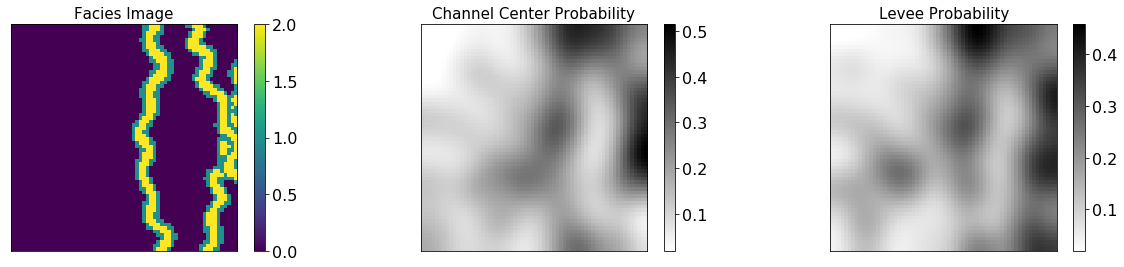

In [13]:
# Sample index to visualize
idx = 3

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# Titles for the subplots
titles = [
    "Facies Image",
    "Channel Center Probability",
    "Levee Probability"
]

# Plot original facies image
im0 = ax[0].imshow(faciesimgs[idx], cmap='viridis')
ax[0].set_title(titles[0], fontsize=15)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# Plot probability map for channel facies
im1 = ax[1].imshow(prob_maps[idx, 0].astype(np.float32), cmap='gray_r')
ax[1].set_title(titles[1], fontsize=15)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

# Plot probability map for mud facies
im2 = ax[2].imshow(prob_maps[idx, 1].astype(np.float32), cmap='gray_r')
ax[2].set_title(titles[2], fontsize=15)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

# Remove axis ticks and tighten layout
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()


### 4. Generate well facies data from facies models

<pre><b>
------------------------ Workflow ------------------------
1. For each facies model:
    - Sample the number of wells (1 to 10)
    - Randomly sample well locations (x, y)
    - Set well indicator to 1 at those locations
2. Multiply facies model with well location mask to get well facies
3. Add well indicator (1) to facies code to distinguish well facies values
----------------------------------------------------------
</b></pre>


In [14]:

faciesimgs = faciesimgs.reshape(-1, 1, 64, 64)
# Initialize binary well indicator cube (same shape as facies models)
well_points = np.zeros(faciesimgs.shape, dtype=np.int8)

# Generate well point indicators
for i in range(faciesimgs.shape[0]):
    # Randomly select number of wells (from 1 to 10) for this sample
    well_points_num = np.random.RandomState(3 * i + i * i).choice(np.arange(1, 11), 1)[0]
    
    # Randomly select well x and y coordinates
    xs = np.random.RandomState(123 * i).choice(faciesimgs.shape[2], well_points_num)
    ys = np.random.RandomState(3 * i + i * i).choice(faciesimgs.shape[3], well_points_num)
    
    # Assign 1 to selected well positions in the well indicator volume
    well_points[i, 0, xs, ys] = 1

# Multiply facies model with well indicator to extract facies at well locations
well_facies = faciesimgs * well_points

# Add 1 to all well facies locations
# Final encoding: 0 = non-well, 1 = mud facies, 2 = channel levee, 3 = channel center facies
well_facies = well_facies + well_points

# Shape confirmation
print("well_facies shape:", well_facies.shape)


well_facies shape: (35640, 1, 64, 64)


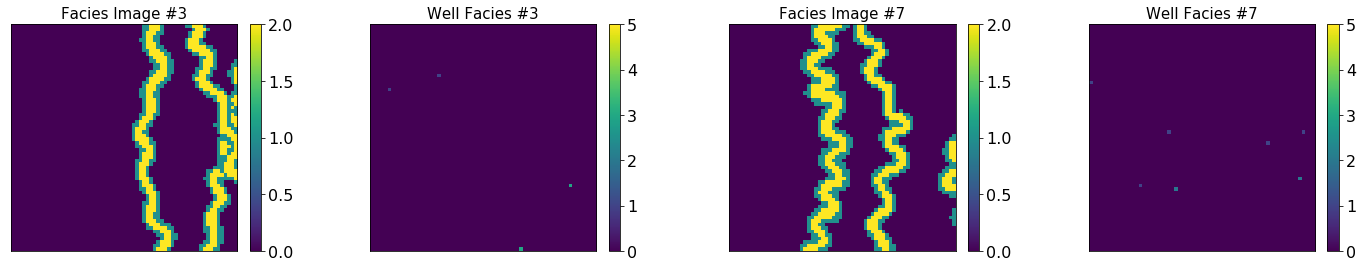

In [15]:
# Choose two indices to display
idx1, idx2 = 3, 7  

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

# Titles
titles = [
    f"Facies Image #{idx1}",
    f"Well Facies #{idx1}",
    f"Facies Image #{idx2}",
    f"Well Facies #{idx2}"
]

# Plot facies image (idx1)
im0 = ax[0].imshow(faciesimgs[idx1, 0], cmap='viridis')
ax[0].set_title(titles[0], fontsize=15)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# Plot well facies (idx1)
im1 = ax[1].imshow(well_facies[idx1, 0], vmin=0, vmax=5)
ax[1].set_title(titles[1], fontsize=15)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

# Plot facies image (idx2)
im2 = ax[2].imshow(faciesimgs[idx2, 0], cmap='viridis')
ax[2].set_title(titles[2], fontsize=15)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

# Plot well facies (idx2)
im3 = ax[3].imshow(well_facies[idx2, 0], vmin=0, vmax=5)
ax[3].set_title(titles[3], fontsize=15)
fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

# Clean up
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

### 5. Split into training and test datasets

In [16]:
# Generate a random permutation of indices
randseq = np.random.RandomState(232).permutation(faciesimgs.shape[0])

# ------------------------ Split facies models ------------------------
faciesimgs_train = faciesimgs[randseq[:32640]]
faciesimgs_test = faciesimgs[randseq[32640:]]

# ------------------------ Split global features ------------------------
labels_cor_train = labels_cor[randseq[:32640]]
labels_cor_test = labels_cor[randseq[32640:]]

# ------------------------ Split probability maps ------------------------
prob_maps_train = prob_maps[randseq[:32640]]
prob_maps_test = prob_maps[randseq[32640:]]

# ------------------------ Split well facies data ------------------------
well_facies_train = well_facies[randseq[:32640]]
well_facies_test = well_facies[randseq[32640:]]

# ------------------------ Print shapes to verify ------------------------
print("Facies:", faciesimgs_train.shape, faciesimgs_test.shape)
print("Global features:", labels_cor_train.shape, labels_cor_test.shape)
print("Probability maps:", prob_maps_train.shape, prob_maps_test.shape)
print("Well facies:", well_facies_train.shape, well_facies_test.shape)

Facies: (32640, 1, 64, 64) (3000, 1, 64, 64)
Global features: (32640, 34) (3000, 34)
Probability maps: (32640, 2, 64, 64) (3000, 2, 64, 64)
Well facies: (32640, 1, 64, 64) (3000, 1, 64, 64)


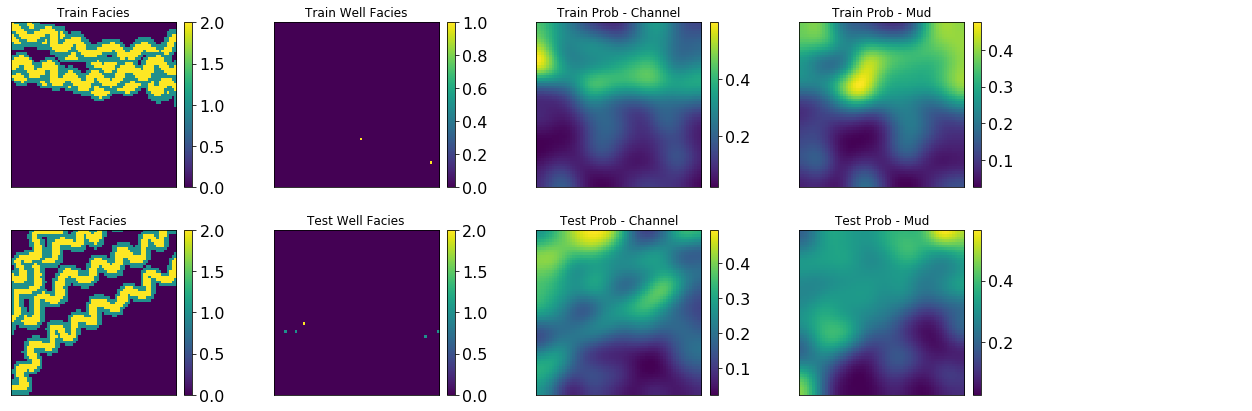

In [17]:
import matplotlib.pyplot as plt

# Random sample indices
i_train = np.random.randint(0, faciesimgs_train.shape[0])
i_test = 1 # np.random.randint(0, faciesimgs_test.shape[0])

# Create plot: 2 rows (train/test), 5 columns (but only use 3 per row)
fig, ax = plt.subplots(2, 5, figsize=(18, 6))
title_fontsize = 12

# ---------- Row 0: Training Sample ----------

# Facies image
im00 = ax[0, 0].imshow(faciesimgs_train[i_train, 0], cmap='viridis')
ax[0, 0].set_title("Train Facies", fontsize=title_fontsize)
fig.colorbar(im00, ax=ax[0, 0], fraction=0.046, pad=0.04)

# Well facies
im01 = ax[0, 1].imshow(well_facies_train[i_train, 0])
ax[0, 1].set_title("Train Well Facies", fontsize=title_fontsize)
fig.colorbar(im01, ax=ax[0, 1], fraction=0.046, pad=0.04)

# Channel probability map
im02 = ax[0, 2].imshow(prob_maps_train[i_train, 0].astype(np.float32))
ax[0, 2].set_title("Train Prob - Channel", fontsize=title_fontsize)
fig.colorbar(im02, ax=ax[0, 2], fraction=0.046, pad=0.04)

# Mud probability map
im03 = ax[0, 3].imshow(prob_maps_train[i_train, 1].astype(np.float32))
ax[0, 3].set_title("Train Prob - Mud", fontsize=title_fontsize)
fig.colorbar(im03, ax=ax[0, 3], fraction=0.046, pad=0.04)

# Empty last column
ax[0, 4].axis("off")

# ---------- Row 1: Test Sample ----------

# Facies image
im10 = ax[1, 0].imshow(faciesimgs_test[i_test, 0], cmap='viridis')
ax[1, 0].set_title("Test Facies", fontsize=title_fontsize)
fig.colorbar(im10, ax=ax[1, 0], fraction=0.046, pad=0.04)

# Well facies
im11 = ax[1, 1].imshow(well_facies_test[i_test, 0])
ax[1, 1].set_title("Test Well Facies", fontsize=title_fontsize)
fig.colorbar(im11, ax=ax[1, 1], fraction=0.046, pad=0.04)

# Channel probability map
im12 = ax[1, 2].imshow(prob_maps_test[i_test, 0].astype(np.float32))
ax[1, 2].set_title("Test Prob - Channel", fontsize=title_fontsize)
fig.colorbar(im12, ax=ax[1, 2], fraction=0.046, pad=0.04)

# Mud probability map
im13 = ax[1, 3].imshow(prob_maps_test[i_test, 1].astype(np.float32))
ax[1, 3].set_title("Test Prob - Mud", fontsize=title_fontsize)
fig.colorbar(im13, ax=ax[1, 3], fraction=0.046, pad=0.04)

# Empty last column
ax[1, 4].axis("off")

# Clean ticks and layout
for a_row in ax:
    for a in a_row:
        a.set_xticks([])
        a.set_yticks([])

plt.tight_layout()
plt.show()


### 6. Store dataset for training GANSim

*Note: When downsampling the facies models into coarser resolutions, a downsampling method with facies priority is used. In this point bar dataset, the priority order is set as: channel center (code 2) > channel levee (code 1) > mud facies (code 0). This ensures that higher-priority geological features are preserved during resolution reduction — for example, if any pixel in a downsampling block contains a channel center, the entire block is assigned that facies in the downsampled image.*

In [19]:
class TFRecordExporter:
    def __init__(self, tfrecord_dir, expected_images, print_progress=True, progress_interval=10):
        self.tfrecord_dir       = tfrecord_dir
        self.tfr_prefix         = os.path.join(self.tfrecord_dir, os.path.basename(self.tfrecord_dir))
        self.expected_images    = expected_images
        self.cur_images         = 0
        self.shape              = None
        self.resolution_log2    = None
        self.tfr_writers        = []
        self.print_progress     = print_progress
        self.progress_interval  = progress_interval
        if self.print_progress:
            print('Creating dataset "%s"' % tfrecord_dir)
        if not os.path.isdir(self.tfrecord_dir):
            os.makedirs(self.tfrecord_dir)
        assert os.path.isdir(self.tfrecord_dir)

    def close(self):
        if self.print_progress:
            print('%-40s\r' % 'Flushing data...', end='', flush=True)
        for tfr_writer in self.tfr_writers:
            tfr_writer.close()
        self.tfr_writers = []
        if self.print_progress:
            print('%-40s\r' % '', end='', flush=True)
            print('Added %d images.' % self.cur_images)

    def choose_shuffled_order(self):  # Note: Images and labels must be added in shuffled order.
        order = np.arange(self.expected_images)
        np.random.RandomState(123).shuffle(order)
        return order

    def add_real_image(self, real_img):
        def downscale_factor(img):
            img_dim = img.shape[1:]
            img_dim_log2 = np.log2(img_dim).astype(int)
            img_dim_log2_dist = img_dim_log2 - np.array([2, 2])
            down_factor = np.where(img_dim_log2_dist > 0, 2, 1)
            return down_factor

        if self.print_progress and self.cur_images % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_images, self.expected_images), end='', flush=True)

        if self.shape is None:
            self.shape = real_img.shape
            self.resolution_log2 = int(np.log2(self.shape[1]))
            assert self.shape[0] in [1, 3]
            assert self.shape[1] == self.shape[2]
            assert self.shape[1] == 2 ** self.resolution_log2
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            for lod in range(self.resolution_log2 - 1):
                tfr_file = self.tfr_prefix + '-1r%02d.tfrecords' % (self.resolution_log2 - lod)
                self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))

        assert real_img.shape == self.shape

        for lod, tfr_writer in enumerate(self.tfr_writers[:-1]):
            if lod:
                real_img = real_img.astype(np.float32)
                fac_x, fac_y = downscale_factor(real_img)

                # Perform facies-priority-based downsampling to lower resolution:
                # (1) Re-encode facies values using descending priority values.
                #     For the point bar dataset, the priority is: abandoned channel (3) > sandy accretion (4) > mud drape (1) > floodplain (0).
                #     Replace each facies code with a temporary decreasing numerical code (e.g., 99, 98, ...), reflecting its priority.
                prior_codes = [2, 1, 0]
                dec_codes = [99. - i for i in range(len(prior_codes))]

                # (2) Replace facies codes in the image with their corresponding priority values
                for code, dec_code in zip(prior_codes, dec_codes):
                    real_img = np.where(real_img == code, dec_code, real_img)

                real_img = np.expand_dims(real_img, axis=-1)

                # (3) Perform 2D downsampling using a block-wise max operation
                real_img = np.concatenate(
                    (
                        real_img[:, 0::fac_x, 0::fac_y],
                        real_img[:, 0::fac_x, fac_y - 1::fac_y],
                        real_img[:, fac_x - 1::fac_x, 0::fac_y],
                        real_img[:, fac_x - 1::fac_x, fac_y - 1::fac_y]
                    ),
                    axis=-1
                )
                real_img = np.max(real_img, axis=-1)

                # (4) Convert temporary priority codes back to original facies codes
                for code, dec_code in zip(prior_codes, dec_codes):
                    real_img = np.where(real_img == dec_code, code, real_img)

            quant = np.rint(real_img).clip(0, 255).astype(np.uint8)
            ex = tf.train.Example(features=tf.train.Features(feature={
                'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
                'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))
            }))
            tfr_writer.write(ex.SerializeToString())
        self.cur_images += 1

    def add_prob_image(self, prob_image):
        if self.print_progress and self.cur_images % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_images, self.expected_images), end='', flush=True)

        if self.shape is None:
            self.shape = prob_image.shape
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            tfr_file = self.tfr_prefix + '-2probimages.tfrecords'
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))

        quant = prob_image.clip(0, 1).astype(np.float16)
        ex = tf.train.Example(features=tf.train.Features(feature={
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))
        }))
        self.tfr_writers[0].write(ex.SerializeToString())
        self.cur_images += 1

    def add_well_facies(self, well_facies):
        if self.print_progress and self.cur_images % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_images, self.expected_images), end='', flush=True)

        if self.shape is None:
            self.shape = well_facies.shape
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            tfr_file = self.tfr_prefix + '-3wellfacies.tfrecords'
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))

        quant = well_facies.astype(np.uint8)
        ex = tf.train.Example(features=tf.train.Features(feature={
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))
        }))
        self.tfr_writers[0].write(ex.SerializeToString())
        self.cur_images += 1

    def add_labels(self, labels):
        if self.print_progress:
            print('%-40s\r' % 'Saving labels...', end='', flush=True)
        assert labels.shape[0] == self.cur_images
        with open(self.tfr_prefix + '-4rxx.labels', 'wb') as f:
            np.save(f, labels.astype(np.float32))

    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.close()


In [20]:
# Path for saving TFRecords of the training dataset
tfrecord_dir_training = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/TrainingData'

# Path for saving TFRecords of the test dataset
tfrecord_dir_test = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/TestData'

In [21]:
with TFRecordExporter(tfrecord_dir_training, faciesimgs_train.shape[0]) as tfr:
    for idx in range(faciesimgs_train.shape[0]):
        tfr.add_real_image(faciesimgs_train[idx])
    tfr.add_labels(labels_cor_train)       

Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/TrainingData"
Added 32640 images.                     


In [22]:
with TFRecordExporter(tfrecord_dir_training, prob_maps_train.shape[0]) as tfr:
    for idx in range(prob_maps_train.shape[0]):
        tfr.add_prob_image(prob_maps_train[idx])     

Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/TrainingData"
Added 32640 images.                     


In [23]:
with TFRecordExporter(tfrecord_dir_training, well_facies_train.shape[0]) as tfr:
    for idx in range(well_facies_train.shape[0]):
        tfr.add_well_facies(well_facies_train[idx])     

Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/TrainingData"
Added 32640 images.                     


#### Store test dataset

In [24]:
 
with TFRecordExporter(tfrecord_dir_test, faciesimgs_test.shape[0]) as tfr:
    for idx in range(faciesimgs_test.shape[0]):
        tfr.add_real_image(faciesimgs_test[idx])
    tfr.add_labels(labels_cor_test)


Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/TestData"
Added 3000 images.                      


In [25]:
with TFRecordExporter(tfrecord_dir_test, prob_maps_test.shape[0]) as tfr:
    for idx in range(prob_maps_test.shape[0]):
        tfr.add_prob_image(prob_maps_test[idx])
   

Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/TestData"
Added 3000 images.                      


In [26]:
with TFRecordExporter(tfrecord_dir_test, well_facies_test.shape[0]) as tfr:
    for idx in range(well_facies_test.shape[0]):
        tfr.add_well_facies(well_facies_test[idx])
   

Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/TestData"
Added 3000 images.                      
